# Deep Learning model의 class weight 조정

## DNN 이용, Class Weight 조정, OverSampling

- Data 는 이전 실습 문제와 동일한 [Credit Card Fraud Detection](https://www.kaggle.com/mlg-ulb/creditcardfraud) - Kaggle

In [31]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Dropout

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from collections import Counter
from sklearn.metrics import confusion_matrix, f1_score
from sklearn.metrics import  accuracy_score, precision_score, recall_score, \
                            roc_curve, roc_auc_score

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
mpl.rcParams['figure.figsize'] = (12, 10)

### Kaggle Credit Card Fraud dataset 다운로드

In [32]:
df = pd.read_csv('https://storage.googleapis.com/download.tensorflow.org/data/creditcard.csv')
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


### 클래스 레이블 불균형 조사

In [33]:
df['Class'].value_counts()

0    284315
1       492
Name: Class, dtype: int64

In [34]:
neg, pos = df['Class'].value_counts().values.tolist()
total = neg + pos
print(f'Total 건수: {total}\nPositive 건수/비율: {pos} ({pos/total*100:.2f}%)')

Total 건수: 284807
Positive 건수/비율: 492 (0.17%)


## Data 전처리 

- 2 일 동안의 data가 00:00:00 부터 발생했으므로 Time을 일중 시간으로 변경 : time / 3600 초 % 24 시간  
- Amount column 은 편차가 크므로 log-scale 로 변환

In [35]:
cleaned_df = df.copy()

# Time 을 일중 시간으로 변환
cleaned_df.loc[:, "Time"] = cleaned_df.loc[:, "Time"].apply(lambda x : x / 3600 % 24) 

# Amount column 은 편차가 크므로 log-scale 로 변환
eps=0.001     
cleaned_df['Amount'] = np.log(cleaned_df.pop('Amount') + eps)

cleaned_df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Class,Amount
0,0.000000,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,0,5.008105
1,0.000000,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,0,0.989913
2,0.000278,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,0,5.936641
3,0.000278,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,0,4.816249
4,0.000556,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,0,4.248367


<AxesSubplot:ylabel='Frequency'>

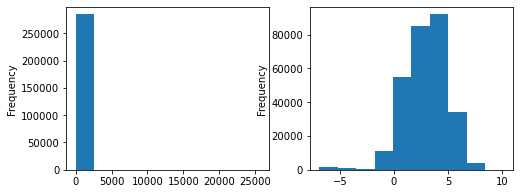

In [36]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 3))
df['Amount'].plot(kind='hist', ax=ax1)
cleaned_df['Amount'].plot(kind='hist', ax=ax2)

In [37]:
labels = np.array(cleaned_df.pop('Class'))
labels

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

In [38]:
features = cleaned_df.values
features.shape

(284807, 30)

<AxesSubplot:ylabel='count'>

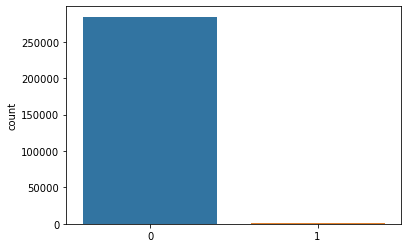

In [39]:
plt.figure(figsize=(6, 4))
sns.countplot(x=labels)

### Dataset 을 Training 과 Test set 으로 분리

In [40]:
X_train, X_test, y_train, y_test = train_test_split(features, labels, 
                                test_size=0.5, random_state=0, stratify=labels)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((142403, 30), (142404, 30), (142403,), (142404,))

In [41]:
print("전체 data의 positive 건수 : ", Counter(labels))
print("Train set 의 positive 건수 : ", Counter(y_train))
print("Test set 의 positive 건수 : ", Counter(y_test))

전체 data의 positive 건수 :  Counter({0: 284315, 1: 492})
Train set 의 positive 건수 :  Counter({0: 142157, 1: 246})
Test set 의 positive 건수 :  Counter({0: 142158, 1: 246})


## Feature Scaling

In [42]:
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test  = sc.transform(X_test)

### Metrics 정의
- model train 중 측정할 metric  정의

In [43]:
METRICS = tf.keras.metrics.AUC(name='auc')

## Simple NN model 정의 - 이진 분류 모델

In [44]:
def make_model():
    model = tf.keras.Sequential([
      Dense(32, activation='relu', input_shape=(X_train.shape[-1],)),
      Dropout(0.2),
      Dense(16, activation='relu'),
      Dropout(0.2),
      Dense(1, activation='sigmoid'),
      ])

    model.compile(
      optimizer = tf.keras.optimizers.Adam(learning_rate=0.01),
      loss = 'binary_crossentropy', metrics=[METRICS, 'accuracy'])

    return model

### Baseline model build

In [45]:
EPOCHS = 100
BATCH_SIZE = 2048

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_auc', 
    verbose=1,
    patience=10,        # no of epochs of no improvement          
    mode='max',        #val_auc 가 10 번 연속 증가 안하면 stop           
    restore_best_weights=True)      # epoch 의 best weight 저장

In [46]:
base_model = make_model()
base_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 32)                992       
                                                                 
 dropout_4 (Dropout)         (None, 32)                0         
                                                                 
 dense_7 (Dense)             (None, 16)                528       
                                                                 
 dropout_5 (Dropout)         (None, 16)                0         
                                                                 
 dense_8 (Dense)             (None, 1)                 17        
                                                                 
Total params: 1,537
Trainable params: 1,537
Non-trainable params: 0
_________________________________________________________________


## Train the model

In [47]:
baseline_history = base_model.fit(X_train, y_train, batch_size=BATCH_SIZE,
                             epochs=EPOCHS, 
                             callbacks=[early_stopping], 
                             validation_data=(X_test, y_test))

Epoch 1/100
70/70 [==============================] - 1s 6ms/step - loss: 0.0479 - auc: 0.7756 - accuracy: 0.9885 - val_loss: 0.0043 - val_auc: 0.9201 - val_accuracy: 0.9994
Epoch 2/100
70/70 [==============================] - 0s 3ms/step - loss: 0.0048 - auc: 0.9287 - accuracy: 0.9993 - val_loss: 0.0038 - val_auc: 0.9243 - val_accuracy: 0.9994
Epoch 3/100
70/70 [==============================] - 0s 3ms/step - loss: 0.0038 - auc: 0.9394 - accuracy: 0.9993 - val_loss: 0.0040 - val_auc: 0.9225 - val_accuracy: 0.9994
Epoch 4/100
70/70 [==============================] - 0s 3ms/step - loss: 0.0037 - auc: 0.9377 - accuracy: 0.9993 - val_loss: 0.0038 - val_auc: 0.9184 - val_accuracy: 0.9994
Epoch 5/100
70/70 [==============================] - 0s 3ms/step - loss: 0.0035 - auc: 0.9500 - accuracy: 0.9993 - val_loss: 0.0037 - val_auc: 0.9225 - val_accuracy: 0.9994
Epoch 6/100
70/70 [==============================] - 0s 3ms/step - loss: 0.0032 - auc: 0.9503 - accuracy: 0.9994 - val_loss: 0.0041 - v

In [48]:
baseline_history.history['val_accuracy'][-1]

0.9993960857391357

## Evaluate Metric

- confusion matrix 를 이용하여 metrics 요약

In [49]:
predictions_baseline  = base_model.predict(X_test)
predictions_baseline.shape

4451/4451 [==============================] - 2s 518us/step


(142404, 1)

In [50]:
predictions_baseline.shape

(142404, 1)

In [51]:
def plot_cm(y_test, y_pred_prob, threshold):
    
    y_pred = y_pred_prob > threshold
    
    cm = confusion_matrix(y_test, y_pred)
    
    print("f1 score:", f1_score(y_test, y_pred))
    print("Accuracy", accuracy_score(y_test, y_pred))
    print("Precision", precision_score(y_test, y_pred))
    print("Recall", recall_score(y_test, y_pred))
    
    plt.figure(figsize=(5,5))

    sns.heatmap(cm, annot=True, fmt="d")
    plt.title('Confusion matrix (threshold>{:.2f}) '.format(threshold))
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')

### Test dataset 으로 모델을 평가 하고, confusion matrix 를 그린다

f1 score: 0.8250539956803455
Accuracy 0.9994311957529283
Precision 0.880184331797235
Recall 0.7764227642276422


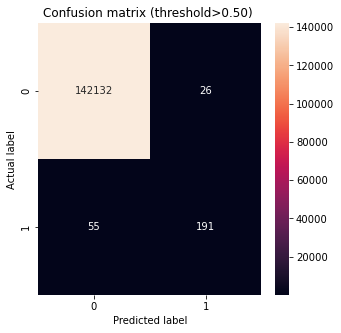

In [52]:
plot_cm(y_test, predictions_baseline, threshold=0.5)

## Class Weight 조정

사용할 positive 샘플이 많지 않기 때문에 가용한 적은 수의 sample 에 classifier 가 더 비중을 두도록 할 수 있다.  이는 모델이 과소 표현된 클래스의 샘플에 `더 많은주의를 기울이도록` 지시하는 데 유용.

step1 - 레이블 및 관련 가중치로 dictionary 정의 
```
class_weight ={0: 0.5008652375006595, 1: 289.43800813008136}
```                
step2 - dictionary를 매개 변수로 공급:  
```
    model.fit(X_train, Y_train, nb_epoch=5, batch_size=32, class_weight=class_weight)
```

- loss function 계산 시 class_weight 에 지정된 대로 가중 평균

In [53]:
neg, pos, total

(284315, 492, 284807)

In [54]:
weight_for_0 = (1 / neg)*(total)
weight_for_1 = (1 / pos)*(total)

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))

Weight for class 0: 1.00
Weight for class 1: 578.88


In [55]:
class_weight

{0: 1.001730475001319, 1: 578.8760162601627}

In [56]:
weighted_model = make_model()

weighted_history = weighted_model.fit(X_train, y_train, 
                                    batch_size=BATCH_SIZE,
                                    epochs=EPOCHS, 
                                    callbacks = [early_stopping], 
                                    validation_data=(X_test, y_test),
                                    class_weight=class_weight) 

Epoch 1/100
70/70 [==============================] - 1s 7ms/step - loss: 0.5636 - auc: 0.9175 - accuracy: 0.8890 - val_loss: 0.1005 - val_auc: 0.9787 - val_accuracy: 0.9838
Epoch 2/100
70/70 [==============================] - 0s 3ms/step - loss: 0.3618 - auc: 0.9737 - accuracy: 0.9622 - val_loss: 0.1148 - val_auc: 0.9841 - val_accuracy: 0.9757
Epoch 3/100
70/70 [==============================] - 0s 3ms/step - loss: 0.3536 - auc: 0.9747 - accuracy: 0.9654 - val_loss: 0.0846 - val_auc: 0.9831 - val_accuracy: 0.9862
Epoch 4/100
70/70 [==============================] - 0s 3ms/step - loss: 0.2471 - auc: 0.9893 - accuracy: 0.9784 - val_loss: 0.0729 - val_auc: 0.9842 - val_accuracy: 0.9850
Epoch 5/100
70/70 [==============================] - 0s 4ms/step - loss: 0.2590 - auc: 0.9888 - accuracy: 0.9662 - val_loss: 0.0576 - val_auc: 0.9858 - val_accuracy: 0.9857
Epoch 6/100
70/70 [==============================] - 0s 3ms/step - loss: 0.2919 - auc: 0.9847 - accuracy: 0.9737 - val_loss: 0.1252 - v

In [57]:
predictions_weighted = weighted_model.predict(X_test)

4451/4451 [==============================] - 2s 502us/step


loss :  0.05755698308348656
auc :  0.9857973456382751
accuracy :  0.985716700553894

f1 score: 0.17851373182552505
Accuracy 0.9857166933513104
Precision 0.09910313901345291
Recall 0.8983739837398373


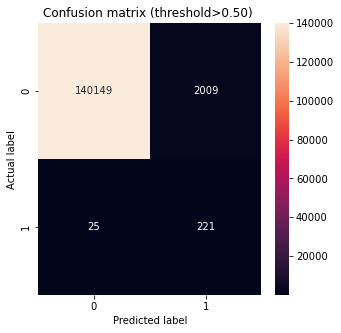

In [58]:
weighted_results = weighted_model.evaluate(X_test, y_test,
                                           batch_size=BATCH_SIZE, verbose=0)

for name, value in zip(weighted_model.metrics_names, weighted_results):
    print(name, ': ', value)
print()

plot_cm(y_test, predictions_weighted, threshold=0.5)

## Plot the ROC

In [59]:
def plot_roc(name, labels, predictions, **kwargs):
    
    fp, tp, _ = roc_curve(labels, predictions)
    auc = roc_auc_score(y_test, predictions)
    
    plt.plot(100*fp, 100*tp, label=f"auc of {name}={auc:.5f}", linewidth=2, **kwargs)
    plt.xlabel('FP [%]')
    plt.ylabel('TP [%]')
    plt.xlim([-0.5,20])
    plt.ylim([80,100.5])
    plt.grid(True)
    ax = plt.gca()
    ax.set_aspect('equal')
    fig = plt.gcf()
    fig.set_size_inches(8, 6)

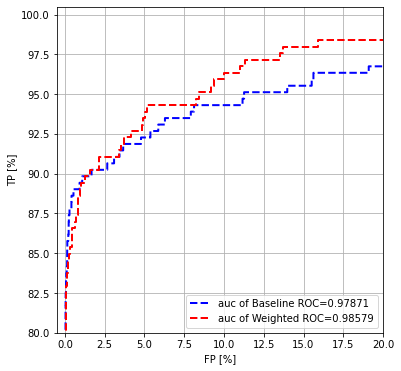

In [60]:
plot_roc("Baseline ROC", y_test, predictions_baseline, color='blue', linestyle='--')

plot_roc("Weighted ROC", y_test, predictions_weighted, color='red', linestyle='--')

plt.legend(loc='lower right')

## Next Step => Over+Under-sampling model과 weight 조절 DNN model 비교